# Model Preparation Challenge
This is an assignment for my thinkful data science course - "Model_Preparation_Challenge"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Model_Preparation_Challenge.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Model_Preparation_Challenge.ipynb) - with all the code exposed in an interactive notebook

My goal in this challenge is to identify features that could be used in a model to predict life-expectancy for a given country and year.  

## Summary

I would begin my modeling using five features: the status of the country (developed vs developing) and the first four PCA components of 10 continuous dimensions (described below).  The four PCA components capture nearly 80% of the variance in the 10 dimensions, and have correlation with life expectancy of .84, .06, .01 and .29 respectively.   This approach captures much of the information in 11 dimensions, with the computational complexity of only 5 dimensions.  

These are the candidate features and my recommendation to include the feature or not in first modeling attempts. 

**candidate features that are recommended:**

* *log HIV/AIDS*: the common log of Deaths per 1 000 live births due to HIV/AIDS (0-4 years) 
* *Income composition of resources*
* *Schooling*: Number of years of Schooling(years)
* *BMI*: Average Body Mass Index of the entire population
* *log thinness 5-9 years*: the common log of prevalence of thinness among children and adolescents for Age 10 to 19 (% )
* *percentage expenditure*: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
* *Diphtheria*: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
* *Polio*: Polio (Pol3) immunization coverage among 1-year-olds (%)
* *Alcohol*: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
* *Hepatitis B*: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)

**candidate features that are not recommended, and why each is excluded:**

Adult Mortality
* definition: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
* why excluded: Predicting life expectancy given death rates is hardly insightful. 

infant deaths: 
* definition: Number of Infant Deaths per 1000 population
* why excluded: Predicting life expectancy given death rates is hardly insightful.

under 5 deaths: 
* definition: Number of under-five deaths per 1000 population
* why excluded: Predicting life expectancy given death rates is hardly insightful.

Measles
* definition: Measles - number of reported cases per 1000 population
* why excluded: low correlation with Life Expectancy

Thinness 1-19 years
* definition: Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
* why excluded: extremely high correlation with another (included) candidate dimension. 

GDP
* definition: Gross Domestic Product per capita (in USD)
* why excluded: Data is missing for a large percentage of countries. 

Population
* definition: population of the country
* why excluded: Data is missing for a large percentage of countries.

The remainder of this analysis is broken into these parts: 

* Data Cleansing
* Univariate analysis
* Bivariate analysis - correlation with Life Expectancy
* Feature selection

In [1]:
#imports
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats

%matplotlib inline

In [2]:
#data load
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

le_raw = pd.read_sql_query('select * from lifeexpectancy',con=engine)
le = le_raw.copy()
# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning

### Missing Values

There are many missing values. I followed these steps to fill missing values:

1. I've first filled missing values with interpolation, with the data sequenced by country and then year.  This filled a small percentage of the missing values.  
2. The remaining missing values did not have data for that country & variable for the before / after years.  The next best fill strategy was to fill with the mean for a given country across all years.  This filled a small portion of the remaining missing values. 
3. A large portion of all the missing values in the raw data still remained missing.  These values are for countries with no data for the given variable across all years.  Some variables had no data for a large percentage (>5%) of countries across all years: 

* population (22%)
* GDP (14%)
* Income composition of resources (6%)
* Schooling (6%)
* Hepatitis B (5%)

I had several options for dealing with these missing values: 
* *Drop the rows:* Dropping the rows that contain these nulls would drop a lot of countries entirely out of the analysis.  Those countries do have a lot of meaningful data in other variables. 
* *Fill with a mean or median across all countries for the given year:*  Filling a large % of values could distort findings, especially in the case of GDP and Population. 
* *Drop the columns:*  Dropping the column entirely only makes sense if the other options would lead to distortions in the analysis.  

I dropped the columns with the most missing data (GDP and population) from the analysis entirely, and filled the others with averages for each year across all the countries.  

In [7]:
#fix column headers
le_raw.columns = le_raw.columns.str.strip()
le.columns = le.columns.str.strip()

In [8]:
#fill missing values
"""
There are significant numbers of missing values in these columns: 
Hepatitis B, GDP, Total Expenditure, Alcohol, 
Income composition of resourcs, Schooling. 

Fill process: 
1. Use interpolation with each country (data is already sequenced 
by country (ascending) then year (descending). 
2. Fill with average value for that country across all years
3. Fill with average across all countries for that year
"""

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']

countries = le["Country"].unique()

#interpolate within country, sequenced by year
for c in countries:
     le.loc[le["Country"] == c, col_list] = le.loc[le["Country"] == c, col_list].interpolate()

#fill with the average for the country across all years
for col in col_list:
    for c in countries:
        country_average = le[le["Country"] == c][col].mean()
        le.loc[(le['Country']==c) & (le[col].isnull()), col] = country_average
        
#any remaining blanks indicate countries that have no data for any
#year for that variable

def test_nulls(df):
    n = len(df)
    cols = df.columns
    num_null = [len(df[df[col].isnull()]) / n for col in df]
    num_null_raw = [len(le_raw[le_raw[col].isnull()]) / n for col in df]
    null_df = pd.DataFrame([cols, num_null_raw, num_null]).transpose()
    null_df.columns = ["col", "# null raw", "# null post filling"]
    print(null_df)

#test_nulls(le)



In [9]:
#Dropping GDP and Pop, filling the remainder with annual average across all countries

#Drop GDP and population
le.drop(columns=["GDP", "Population"], inplace=True)

col_list.remove("GDP")
col_list.remove("Population")

#Fill with annual average across all countries
#DON'T KNOW WHY THIS ISN'T FILLING ALL REMAINING NULLS#
#df[(df['A']==12.0) & (df['D'].isnull())] = 400

years = le["Year"].unique()
for col in col_list:
    for y in years:
        le.loc[(le['Year']==y) & (le[col].isnull()), col] = le[le["Year"] == y][col].mean()
        #le[(le["Year"] == y) & (le[col].isnull())][col] = le[le["Year"] == y][col].mean()

#Filling with overall average until I can figure out why the above isn't workign
# for col in col_list:
#         le[col].fillna(le[col].mean(), inplace=True)
        
#affirm that there are no more missing values
#test_nulls(le)

### Outliers:

There are outliers (at 3 standard deviation Z score threshold) for every continuous variable but one (BMI).  See visual depiction and statistical test for each variable below.  

Extreme values can dramatically impact the analysis by, for example, pulling means far from the median or growing the standard deviations.  In cases where there is likely measurement error, I've modified the observiations through winsorization.   In cases where there are statistically extreme values but where I have no reason to suspect measurement error, I have prefered a log transformation, relying on winsorization only for variables with zero values.  

Here I've outlined each concern by issue type, along with how I've altered the data to reduce the number and impact of outliers.  

**Measurement errors:** 

Issue: Infant mortality per thousand observations is far too high in many cases (e.g. greater than 1000).    

Issue: Under-five deaths per 1000 births are far too high in many cases. the highest rate in 2017 per the world bank is 127 (Somalia).  
ACTION: I have windsorized on the high side. 

**other extreme observations:**
These are extreme values statistically, but I have no semantic reason to distrust the measurement. 

Issue: a variable has just a few outliers (beyond 3 standard deviations) and they are just beyond that thresshold: 
- Life expectancy
- Hepatitis B
- Alcohol

Action: Do nothing. Acknowledge the outliers but accept them as reasonable, actual observations that are unlikely to impact the analysis. 

Issue: outliers on the high side, all values postive & non-zero:
- Adult Mortality
- Alcohol
- Measles
- Total Expenditure
- HIV Aids
- thinness 1-19
- thinness 1-5

Action: take the log of these measures

Issue: outliers on the low side, all values positive & non-zero:
- Polio
- Diptheria

Action: take the log.

Issue: Outliers high, and variable has negative or zero-values:

- Infant deaths
- Measles
- Under 5 deaths
- Percentage expenditure

Action: winsorize high

Issue: Outliers low and high, and variable has negative or zero-values:

- schooling

Action: winsorize low and high

Issue: Outliers low and high, and variable has negative or zero-values:

- income composition

Action: winsorize low

**Metadata likely inaccurate**

Issues: 
* Measles is defined as reported cases per 1000 population.  But the average is 2419 (i.e. >1000).  I will assume the definition is wrong.
* Mean body mass index is extremely high.  WHO (purported source of this data) says obese is >25 for an adult mean.  The mean for these countries (for their entire populations) being over 40 is not reasonable). I will assume that the metric is different than a typical BMI metric but the same general meaning. 
* Schooling is defined as "Number of years of Schooling(years)".  These are too high by that definition.  Compare to the UN Human Development Reports.  I suspect the definition is inaccurate - perhaps it's the average oldest age at which school was attended? 

Action: Assume that the metadata is incorrect and proceed. 

### Other Data Quality Concers

**Unclear meaning:**

Issues: 
* Percentage Expenditure is the ratio of total expenditure on health as a percentage of GDP per Capita.  This is strange combination.  It's not clear why one would not take the proporiton of two per capita measures or two total measures. 

* Unclear what "income composition of resources" really means.  The Kaggle metatdata is difficult to decipher: "Human Development Index in terms of income composition of resources (index ranging from 0 to 1"

Action: I will use these variables cautiously.



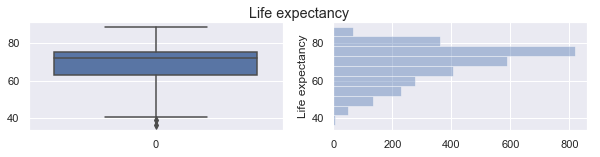

For column Life expectancy...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 2 at threshold 3




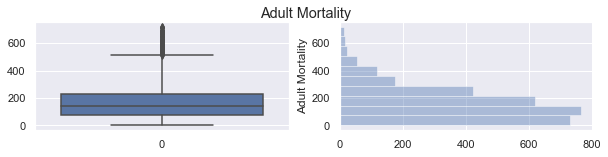

For column Adult Mortality...
Number of outliers (up-side) is: 40 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




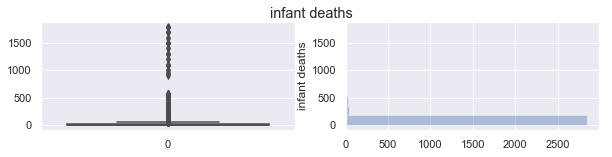

For column infant deaths...
Number of outliers (up-side) is: 37 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




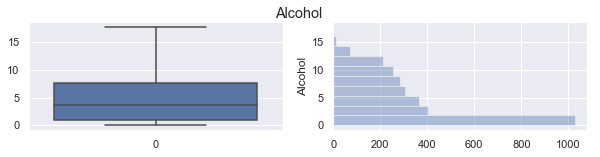

For column Alcohol...
Number of outliers (up-side) is: 3 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




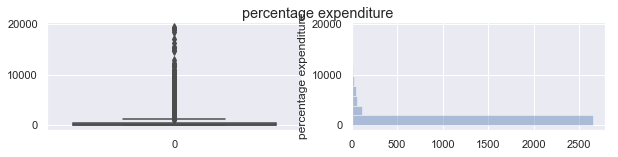

For column percentage expenditure...
Number of outliers (up-side) is: 84 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




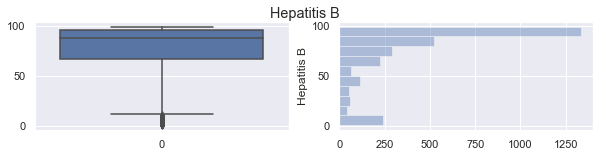

For column Hepatitis B...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




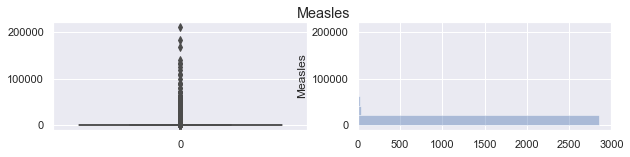

For column Measles...
Number of outliers (up-side) is: 48 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




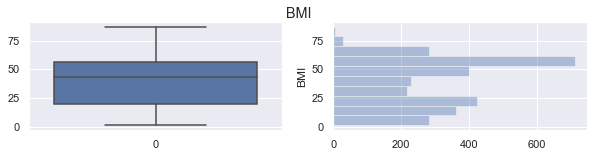

For column BMI...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




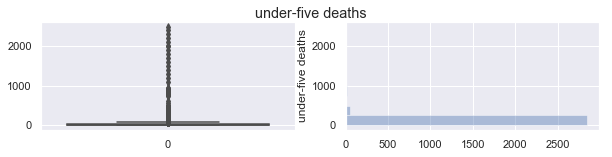

For column under-five deaths...
Number of outliers (up-side) is: 34 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




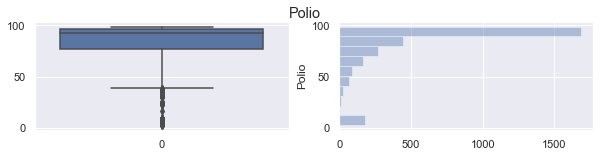

For column Polio...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 178 at threshold 3




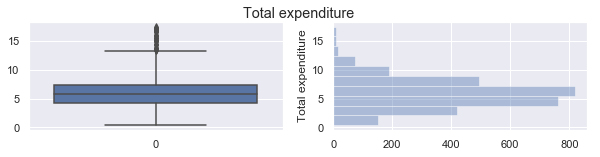

For column Total expenditure...
Number of outliers (up-side) is: 27 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




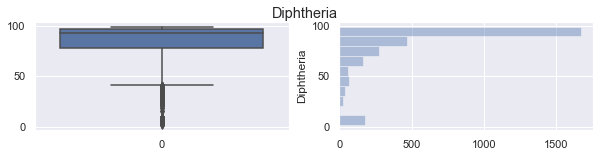

For column Diphtheria...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 176 at threshold 3




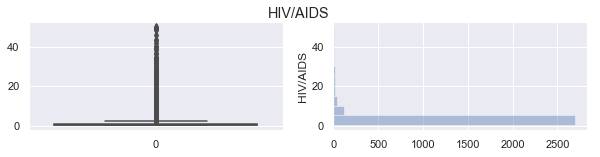

For column HIV/AIDS...
Number of outliers (up-side) is: 69 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




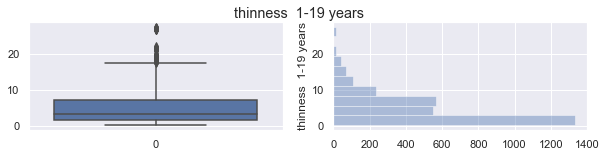

For column thinness  1-19 years...
Number of outliers (up-side) is: 54 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




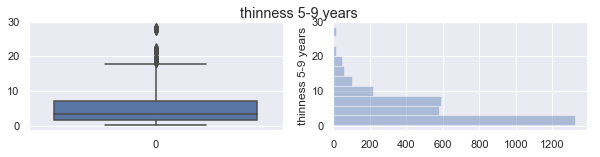

For column thinness 5-9 years...
Number of outliers (up-side) is: 57 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




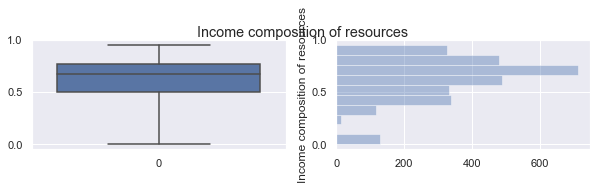

For column Income composition of resources...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 130 at threshold 3




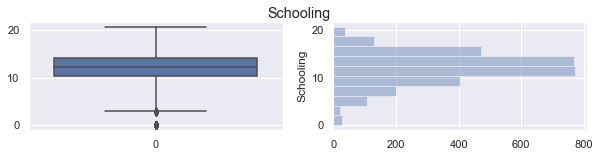

For column Schooling...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 28 at threshold 3




In [11]:
#find outliers

sns.set()

def z_count(df, col, threshold):
    """
    prints the number of observatins for each of the z scores 
    between the min and max (inclusive)
    """
    
    print("For column {}...".format(str(col)))
    z_scores = zscore(df[col])
    num_outliers_up = len(np.where(z_scores > threshold)[0])
    num_outliers_down = len(np.where(z_scores < threshold*-1)[0])
    print("Number of outliers (up-side) is: {} at threshold {}".format(num_outliers_up, threshold))
    print("Number of outliers (down-side) is: {} at threshold {}".format(num_outliers_down, threshold))
    print("\n")

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling']

for col in col_list:
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(col)
    plt.subplot(1,2,1)
    sns.boxplot(data=le[col], whis=1.9)
    plt.subplot(1,2,2)
    sns.distplot(le[col], bins = 10, kde=False, vertical=True)
    plt.show()
    z_count(le, col, 3)



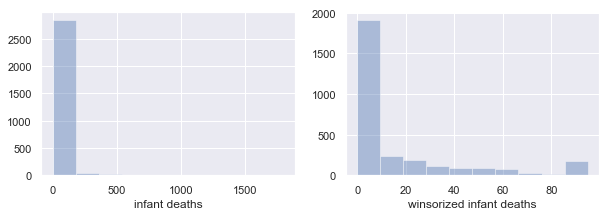

For column winsorized infant deaths...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




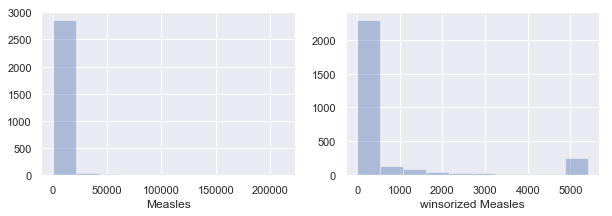

For column winsorized Measles...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




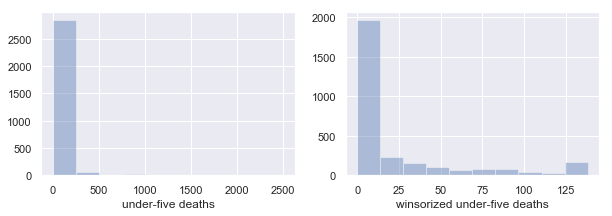

For column winsorized under-five deaths...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




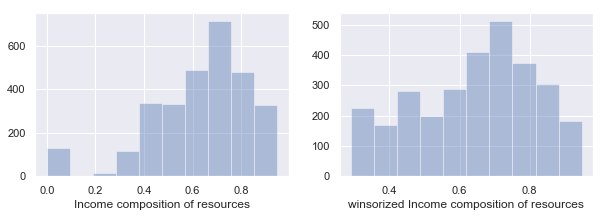

For column winsorized Income composition of resources...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




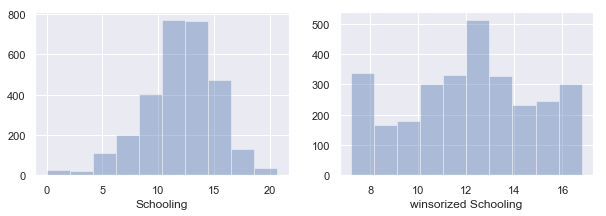

For column winsorized Schooling...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




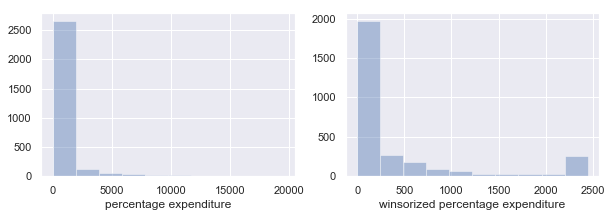

For column winsorized percentage expenditure...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




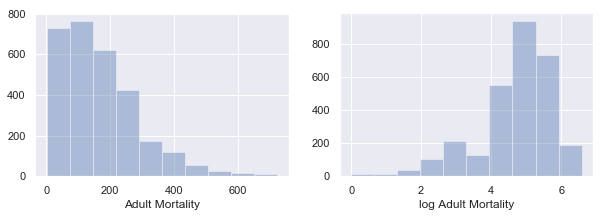

For column log Adult Mortality...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 30 at threshold 3




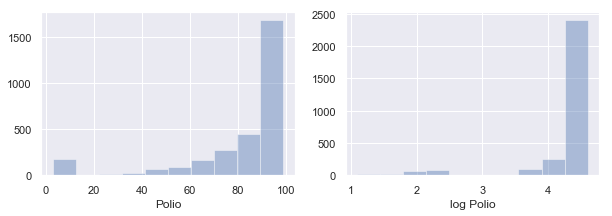

For column log Polio...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 178 at threshold 3




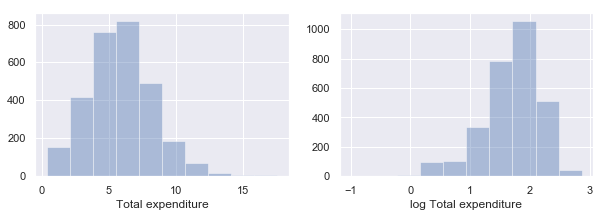

For column log Total expenditure...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 33 at threshold 3




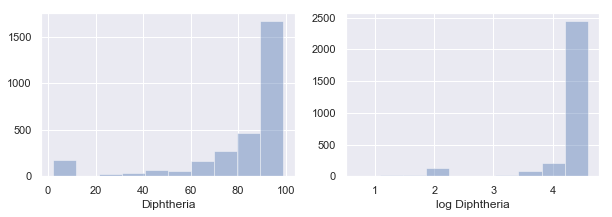

For column log Diphtheria...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 176 at threshold 3




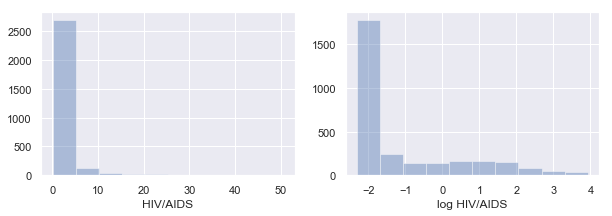

For column log HIV/AIDS...
Number of outliers (up-side) is: 13 at threshold 3
Number of outliers (down-side) is: 0 at threshold 3




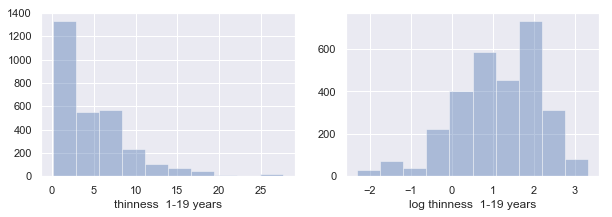

For column log thinness  1-19 years...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 28 at threshold 3




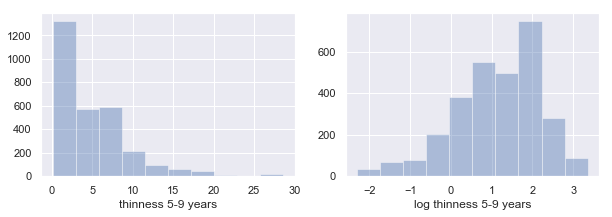

For column log thinness 5-9 years...
Number of outliers (up-side) is: 0 at threshold 3
Number of outliers (down-side) is: 37 at threshold 3




In [12]:
#manage outliers
#note that even after log transformation, 
#several variables still have some outliers. I'm leaving those
#as they don't seem to be due to measurement error. 

zero_outs = ['infant deaths', 'Measles', 'under-five deaths',
             'Income composition of resources', 'Schooling', 
            'percentage expenditure']
non_zero_outs = ['Adult Mortality', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
       'thinness 5-9 years']

#Windosorize for both measurement error and for outliers of variables with zero values
le["winsorized infant deaths"] = winsorize(le["infant deaths"], (0, 0.05))
le["winsorized Measles"] = winsorize(le["Measles"], (0, 0.08))
le["winsorized under-five deaths"] = winsorize(le["under-five deaths"], (0, 0.05))
le["winsorized Income composition of resources"] = winsorize(le["Income composition of resources"], (0.05, 0))
le["winsorized Schooling"] = winsorize(le["Schooling"], (0.08, 0.05))
le["winsorized percentage expenditure"] = winsorize(le["percentage expenditure"], (0.0, 0.08))

#log columns with outliers with all positive, non-zero values
for col in non_zero_outs: 
    le["log {}".format(col)] = np.log(le[col])


for col in zero_outs: 
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.distplot(le[col], bins = 10, kde=False)
    colname = "winsorized {}".format(col)
    plt.subplot(1,2,2)
    sns.distplot(le[colname], bins = 10, kde=False)
    plt.show()
    z_count(le, colname, 3)
for col in non_zero_outs:
    plt.figure(figsize=(10, 3))
    plt.subplot(1,2,1)
    sns.distplot(le[col], bins = 10, kde=False)
    plt.subplot(1,2,2)
    colname = "log {}".format(col)
    sns.distplot(le[colname], bins = 10, kde=False)
    plt.show()
    z_count(le, colname, 3)




In [28]:
#describe of cleaned data
le.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,log Polio,log Total expenditure,log Diphtheria,log HIV/AIDS,log thinness 1-19 years,log thinness 5-9 years,PCA0,PCA1,PCA2,PCA3
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2.938000e+03,2.938000e+03,2.938000e+03
mean,2007.518720,69.231777,164.741882,30.303948,4.60024,738.251295,75.832054,2419.592240,38.323713,42.035739,...,4.299985,1.679507,4.294785,-1.221949,1.134315,1.122592,7.739063e-17,-4.353223e-17,2.902149e-17,4.262531e-17
std,4.613841,9.508362,124.083816,117.926501,4.02767,1987.914858,27.928179,11467.272489,19.929396,160.445548,...,0.624129,0.476577,0.629096,1.613377,1.038579,1.071781,2.136847e+00,1.281095e+00,9.328621e-01,8.321085e-01
min,2000.000000,36.300000,1.000000,0.000000,0.01000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.098612,-0.994252,0.693147,-2.302585,-2.302585,-2.302585,-4.369559e+00,-2.526373e+00,-2.794960e+00,-2.063133e+00
25%,2004.000000,63.200000,74.000000,0.000000,0.93000,4.685343,67.000000,0.000000,19.400000,0.000000,...,4.343805,1.453953,4.356709,-2.302585,0.470004,0.470004,-1.634120e+00,-9.610294e-01,-6.175271e-01,-5.975562e-01
50%,2008.000000,72.000000,144.000000,3.000000,3.77500,64.912906,88.000000,17.000000,43.000000,4.000000,...,4.532599,1.750937,4.532599,-2.302585,1.223775,1.223775,-3.039755e-01,-2.159308e-01,-1.970486e-02,-2.906895e-02
75%,2012.000000,75.600000,227.000000,22.000000,7.67750,441.534144,96.000000,360.250000,56.100000,28.000000,...,4.574711,2.005526,4.574711,-0.223144,1.960095,1.974081,1.756640e+00,7.410605e-01,6.407630e-01,5.741443e-01
max,2015.000000,89.000000,723.000000,1800.000000,17.87000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,...,4.595120,2.867899,4.595120,3.923952,3.321432,3.353407,5.314014e+00,5.782967e+00,3.850216e+00,2.832007e+00


In [29]:
#example rows
le.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,log Polio,log Total expenditure,log Diphtheria,log HIV/AIDS,log thinness 1-19 years,log thinness 5-9 years,PCA0,PCA1,PCA2,PCA3
0,Afghanistan,2015,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,1.791759,2.099244,4.174387,-2.302585,2.844909,2.850707,2.932304,0.658252,0.983823,1.296178
1,Afghanistan,2014,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,4.060443,2.101692,4.127134,-2.302585,2.862201,2.862201,2.390477,-0.199340,0.622720,1.303000
2,Afghanistan,2013,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,...,4.127134,2.095561,4.158883,-2.302585,2.873565,2.873565,2.342784,-0.367352,0.576878,1.283417
3,Afghanistan,2012,Developing,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,...,4.204693,2.142416,4.204693,-2.302585,2.884801,2.890372,2.264976,-0.593151,0.515774,1.259757
4,Afghanistan,2011,Developing,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,...,4.219508,2.063058,4.219508,-2.302585,2.901422,2.901422,2.335718,-0.704260,0.543998,1.184314


### Univariate Analysis

The distributions of all of the variables are shown.  Above (under data cleaning), find the distributions of transformed variables, alongside it's pre-transformed version.  

Below find the distributions of variables that are not transformed. 

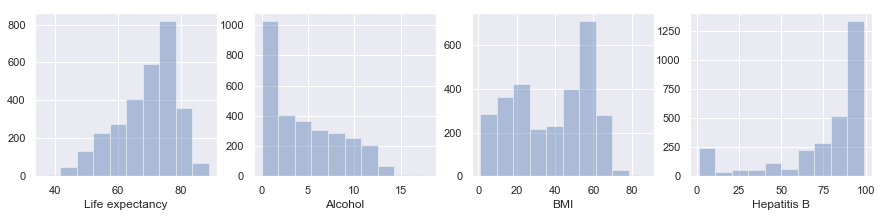

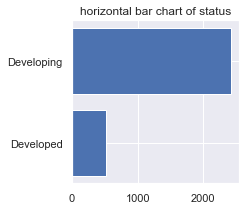

In [13]:
#un-transformed variable distributions

#continuous
untransf = ['Life expectancy', 'Alcohol', 'BMI', 'Hepatitis B']

i=1
plt.figure(figsize=(15, 3))
for col in untransf:
    plt.subplot(1,4,i)
    sns.distplot(le[col], bins = 10, kde=False)
    i += 1
plt.show()

# bar chart of categorical variables
plt.figure(figsize=(3,3))
plt.barh(le.groupby("Status")["Status"].count().index, 
        le.groupby("Status")["Status"].count())
plt.title("horizontal bar chart of status")

plt.show()

### Bivariate analysis: Correlation with Life Expectancy

Categororical: 

Status: The two levels of status (developing and developed) have different mean life expectancies that are stasticially significant at p <0.05. 


Continuous: 

The continuous variables have a wide variation of correlations with life expectancy. A scatter with life expectancy for each is shown below, along with it's correlation with life expectancy.  There are 23 candidate features (including transformations) whose correlations with *Life Expectancy* are > 0.3.  These are included in the table below.

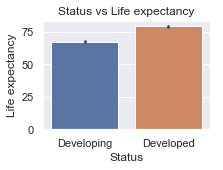

t-test between groups Developing and Developed is significant:  p = 1.778895704879565e-170:


In [14]:
#life-expectancy by country status
def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""

    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.show()

    #t-test
    for i in range(0, len(unique_vals)):
        for j in range(i+1, len(unique_vals)):
            t, p = stats.ttest_ind(
                df[df[cat]==unique_vals[i]][cont], 
                df[df[cat]==unique_vals[j]][cont])
            if p < threshold: 
                print("t-test between groups {0} and {1} is significant:  p = {2}:"
                      .format(unique_vals[i], unique_vals[j], p))
                
cat_to_cont(le, "Status", "Life expectancy", .05)

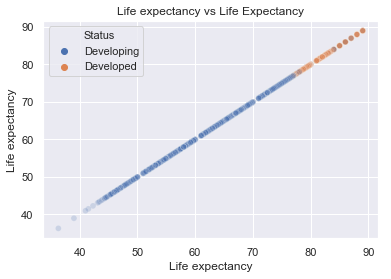

Correlation between Life expectancy and Life Expectancy is: 0.9999999999999998


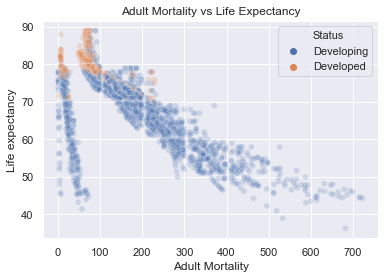

Correlation between Adult Mortality and Life Expectancy is: -0.6963794637029008


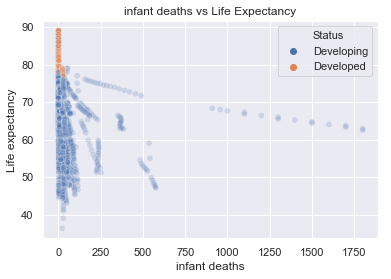

Correlation between infant deaths and Life Expectancy is: -0.1967051478231283


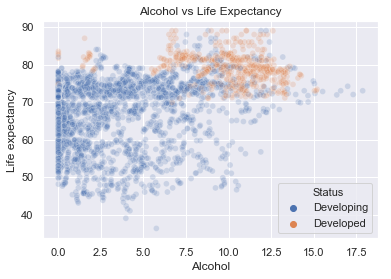

Correlation between Alcohol and Life Expectancy is: 0.40360803122993216


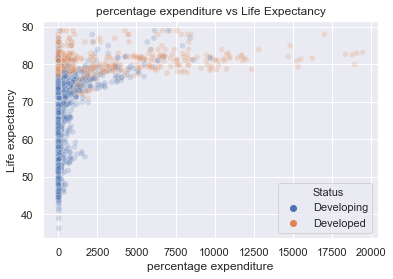

Correlation between percentage expenditure and Life Expectancy is: 0.3815426339299434


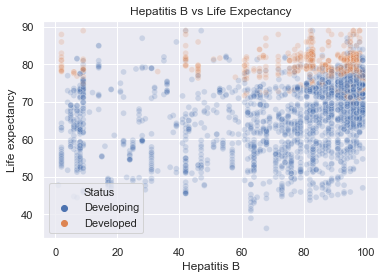

Correlation between Hepatitis B and Life Expectancy is: 0.3059327512537155


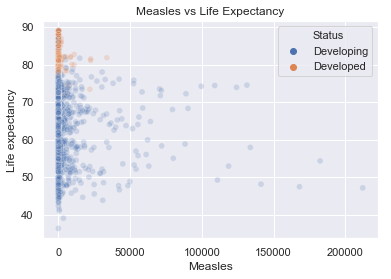

Correlation between Measles and Life Expectancy is: -0.1577138123388764


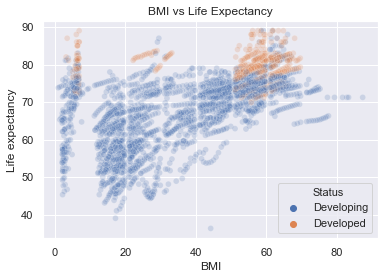

Correlation between BMI and Life Expectancy is: 0.5603073614549585


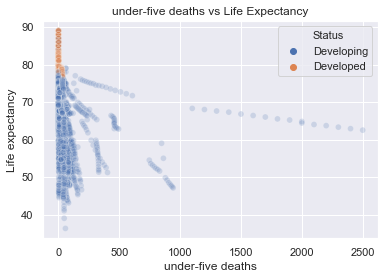

Correlation between under-five deaths and Life Expectancy is: -0.2226748112253477


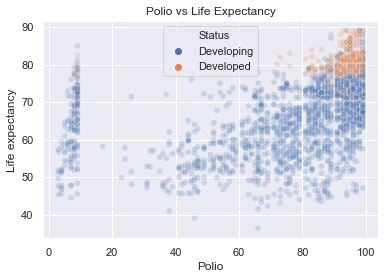

Correlation between Polio and Life Expectancy is: 0.45914287285155525


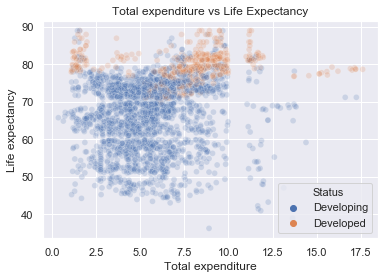

Correlation between Total expenditure and Life Expectancy is: 0.22634006609213156


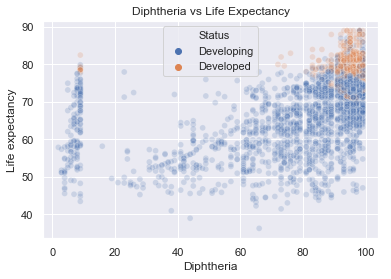

Correlation between Diphtheria and Life Expectancy is: 0.47381659362685113


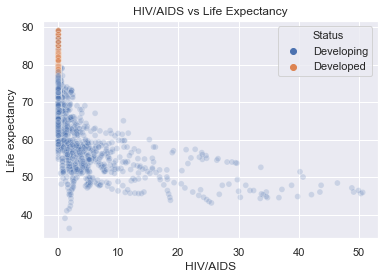

Correlation between HIV/AIDS and Life Expectancy is: -0.5566474721683601


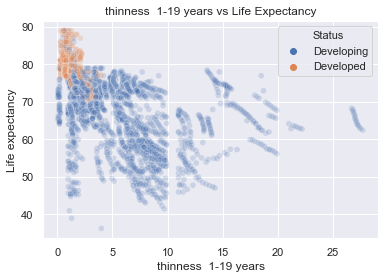

Correlation between thinness  1-19 years and Life Expectancy is: -0.47274563913528966


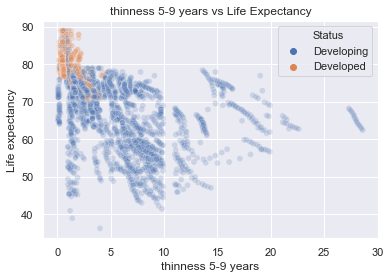

Correlation between thinness 5-9 years and Life Expectancy is: -0.46721657152484347


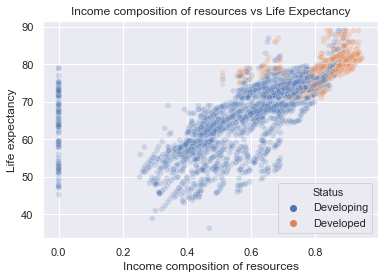

Correlation between Income composition of resources and Life Expectancy is: 0.6941363766667674


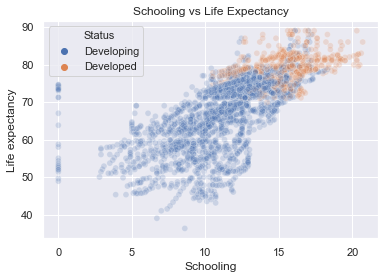

Correlation between Schooling and Life Expectancy is: 0.7160603030408579


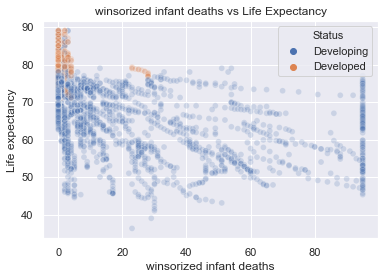

Correlation between winsorized infant deaths and Life Expectancy is: -0.5096971467190313


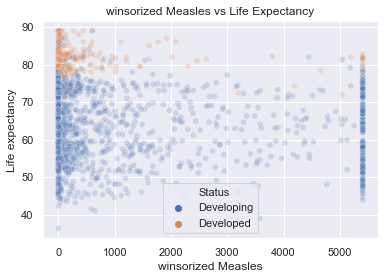

Correlation between winsorized Measles and Life Expectancy is: -0.2754078971731193


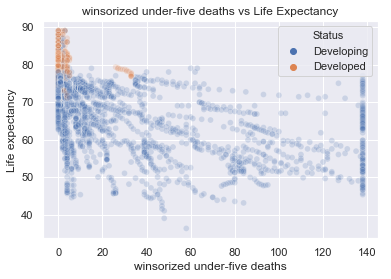

Correlation between winsorized under-five deaths and Life Expectancy is: -0.5408202810298284


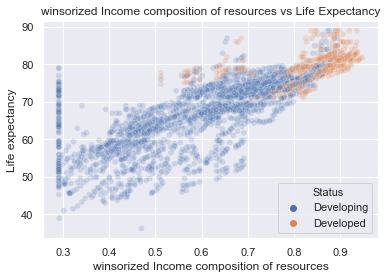

Correlation between winsorized Income composition of resources and Life Expectancy is: 0.7917890960769188


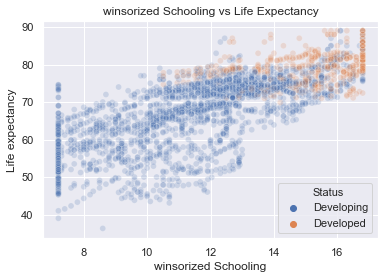

Correlation between winsorized Schooling and Life Expectancy is: 0.752432281558229


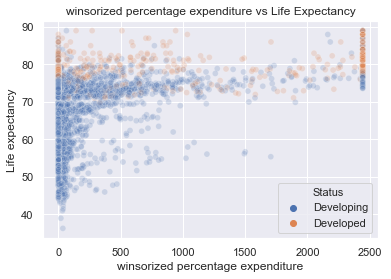

Correlation between winsorized percentage expenditure and Life Expectancy is: 0.47512116738974525


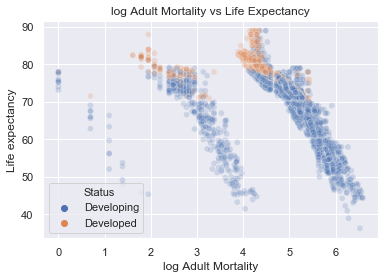

Correlation between log Adult Mortality and Life Expectancy is: -0.4474450498011606


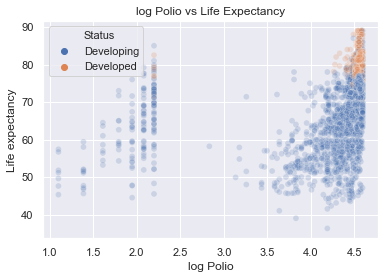

Correlation between log Polio and Life Expectancy is: 0.3186125968445568


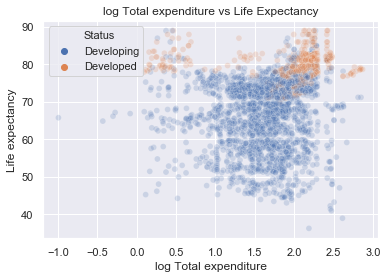

Correlation between log Total expenditure and Life Expectancy is: 0.16790532845048922


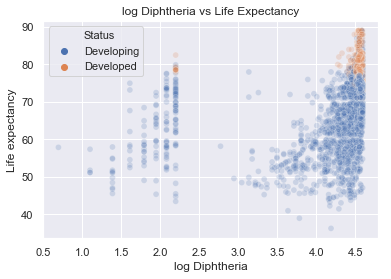

Correlation between log Diphtheria and Life Expectancy is: 0.33591704519977866


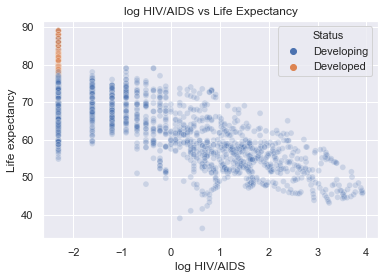

Correlation between log HIV/AIDS and Life Expectancy is: -0.8131827884929773


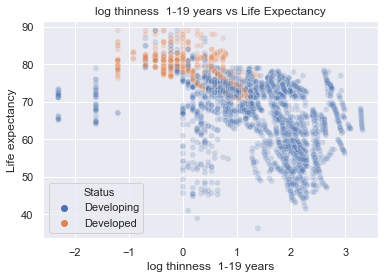

Correlation between log thinness  1-19 years and Life Expectancy is: -0.5262514310980826


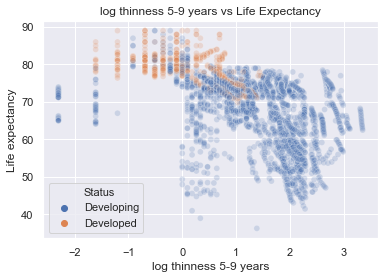

Correlation between log thinness 5-9 years and Life Expectancy is: -0.5313837973923791


,feature,LE correlation,abs LE correlation
0,Life expectancy,1.000000,1.000000
27,log HIV/AIDS,-0.813183,0.813183
20,winsorized Income composition of resources,0.791789,0.791789
21,winsorized Schooling,0.752432,0.752432
16,Schooling,0.716060,0.716060
1,Adult Mortality,-0.696379,0.696379
15,Income composition of resources,0.694136,0.694136
7,BMI,0.560307,0.560307
12,HIV/AIDS,-0.556647,0.556647
19,winsorized under-five deaths,-0.540820,0.540820


In [15]:
#continuous variable correlations

col_list = ['Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure',
       'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio',
       'Total expenditure', 'Diphtheria', 'HIV/AIDS',
       'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling',
       'winsorized infant deaths', 'winsorized Measles',
       'winsorized under-five deaths',
       'winsorized Income composition of resources',
       'winsorized Schooling', 'winsorized percentage expenditure',
       'log Adult Mortality', 'log Polio', 'log Total expenditure',
       'log Diphtheria', 'log HIV/AIDS', 'log thinness  1-19 years',
       'log thinness 5-9 years']
    
def get_corr(col):
    sns.scatterplot(le[col], le["Life expectancy"], alpha=.2, hue=le["Status"])
    plt.title("{0} vs Life Expectancy".format(col))
    plt.show()
    le_corr=le["Life expectancy"].corr(le[col])
    print("Correlation between {} and Life Expectancy is: {}".format(col, le_corr))
    return le_corr


corr_list = [get_corr(col) for col in col_list]

# correlations with life expectancy 

#corr_list.reverse()

abs_corrs = [abs(x) for x in corr_list]

col_le_corrs = pd.DataFrame(
    {'feature': col_list,
     'LE correlation': corr_list,
     'abs LE correlation': abs_corrs
    })

col_le_corrs.sort_values(by="abs LE correlation", inplace=True, ascending=False)
col_le_corrs

### Choosing features

There are 23 candidate features whose correlations with *Life Expectancy* are > 0.3.  I've thinned these down as follows: 

* Six of the candidates are *infant mortality*, *under five deaths* and *adult mortality* and their transformed versions.  Including them in the model would be like saying "I can predict how long people live if you tell me when they die."  Not exactly a terrific insight.  So I won't include those.  

* I'll also remove *HIV/AIDS*, *Schooling*, *Income Composition of resources*, *percentage expenditure*, *log polio*, *thinness 1-19*, *thinness 5-9*, *log Diphtheria*, and *income composition of resources*  because the transformed / un-transformed version of each is also in the list, with better correlation with life expectancy.  

The correlation matrix for the remaining features are shown below. You can see that there is considerable cross correlation. *log thinness 5-9 years* and *log thinness 1-19 years* are so highly correlated with each other, that I'll drop one of them.  

Given the considerable correlation between the remaining 10 candidate features, a PCA analysis is useful to reduce dimensionality.  The top four PCA components capture nearly 80% of the variance in the 10 remaining canidate features, and have correlation with life expectancy of .84, .06, .01 and .29 respectively.  These four components and the status variable are the five dimensions I recommend using as one starts modeling.     

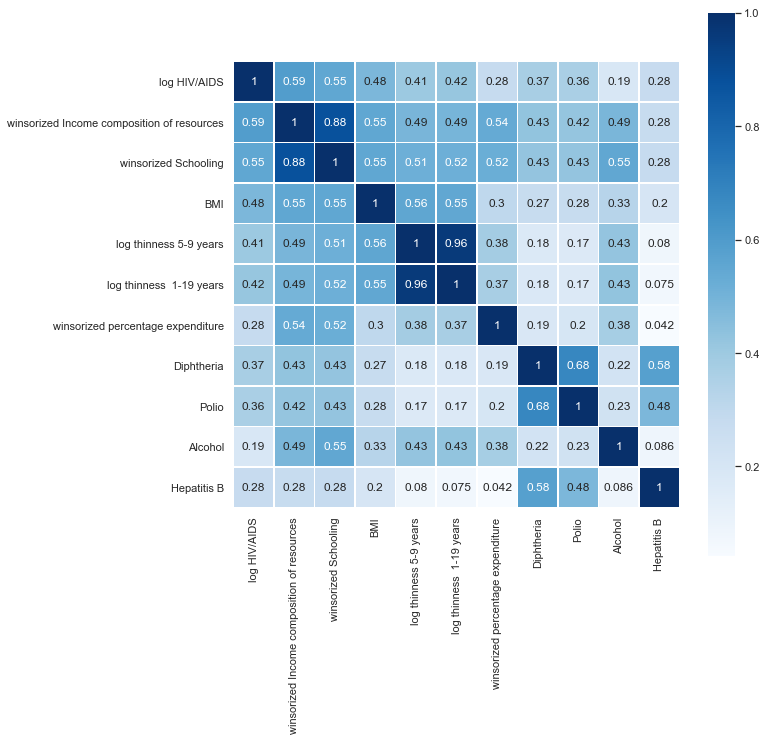

In [30]:
#correlation matrix for candidate features

col_list = list(col_le_corrs[col_le_corrs["abs LE correlation"]>.3]["feature"])

#remove columns that are no longer candidates
for x in ["Income composition of resources",
          "winsorized under-five deaths", "winsorized infant deaths","log Diphtheria" ]:
    col_list.remove(x)
    
for x in ["Life expectancy", "HIV/AIDS", "Schooling", "Adult Mortality", "percentage expenditure", 
      "log Adult Mortality", "log Polio",'thinness  1-19 years', 'thinness 5-9 years']:
    col_list.remove(x)

top_feat_corrs = le[col_list].corr()

plt.figure(figsize=(10,10))
g=sns.heatmap(le[col_list].corr().applymap(abs), square=True, annot=True, linewidths=.5, cmap="Blues")

col_list.remove("log thinness  1-19 years")

Text(0.5, 1.0, 'cumulative variance described by PCA components')

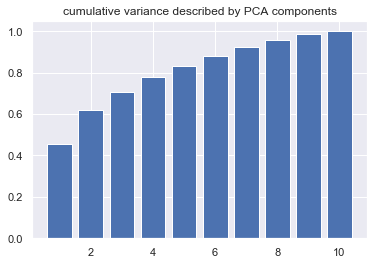

In [17]:
#Calc PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
exp = le[col_list]
X = StandardScaler().fit_transform(exp)

# execute PCA analysis for just the first dimension
sklearn_pca = PCA(n_components=10)
Y_sklearn = sklearn_pca.fit_transform(X)


#plot PCA component cum variance explained
total=0
cums = []

for x in sklearn_pca.explained_variance_ratio_:
    total += x
    cums.append(total)

plt.bar(range(1, len(sklearn_pca.explained_variance_ratio_) + 1, 1), cums)
plt.title("cumulative variance described by PCA components")



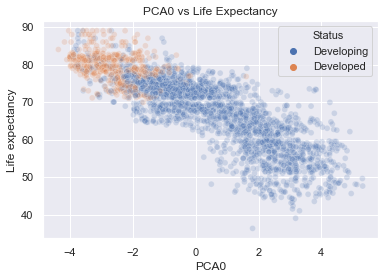

Correlation between PCA0 and Life Expectancy is: -0.8491724562860592


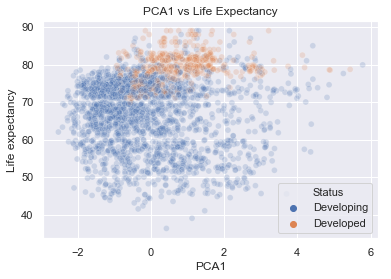

Correlation between PCA1 and Life Expectancy is: 0.048400766427221346


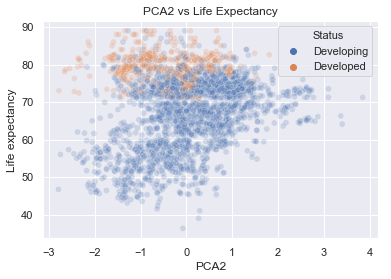

Correlation between PCA2 and Life Expectancy is: 0.17643843940625395


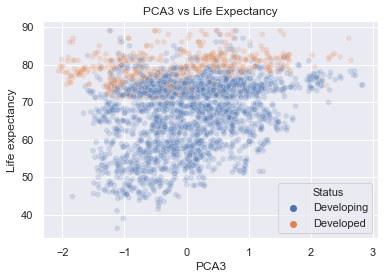

Correlation between PCA3 and Life Expectancy is: 0.1913823772456606


In [18]:
#scatter and correlation of top 4 PCA components and Life Expectancy
#for col in Y_sklearn[:3]: get_corr(col) 

for pca in range(0,4,1):
    le["PCA{}".format(pca)] = Y_sklearn[...,pca]

for pca in range(0,4,1):
    get_corr("PCA{}".format(pca))